<a href="https://colab.research.google.com/github/AhmadAkbariR/deepxde/blob/master/examples/operator/elasticity-2D-AAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @ 2D elastic square domain --> PINN-DeepONet

"""Backend supported: tensorflow, pytorch, paddle"""

import os
os.environ['DDE_BACKEND'] = 'pytorch'
try:
   import deepxde as dde
except ImportError:
   !pip install deepxde

#import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
current_backend = dde.backend.backend_name
print("Current default backend is:", current_backend)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Current default backend is: pytorch
Using device: cuda


Compiling model...
'compile' took 10.002339 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.23e+00, 1.09e+00, 1.12e+00]    [9.58e+00, 1.24e+00, 1.05e+00]    []  
1000      [2.02e-03, 8.87e-04, 1.07e-03]    [2.11e-03, 1.24e-03, 1.04e-03]    []  
2000      [1.01e-03, 5.51e-04, 3.00e-04]    [1.23e-03, 7.81e-04, 5.03e-04]    []  
3000      [4.07e-04, 2.67e-04, 1.95e-04]    [4.27e-04, 4.05e-04, 3.02e-04]    []  
4000      [1.21e-03, 2.67e-04, 1.12e-04]    [1.19e-03, 2.90e-04, 2.40e-04]    []  
5000      [4.63e-04, 3.72e-04, 6.99e-05]    [4.16e-04, 3.85e-04, 1.66e-04]    []  

Best model at step 3000:
  train loss: 8.70e-04
  test loss: 1.13e-03
  test metric: []

'train' took 562.977280 s



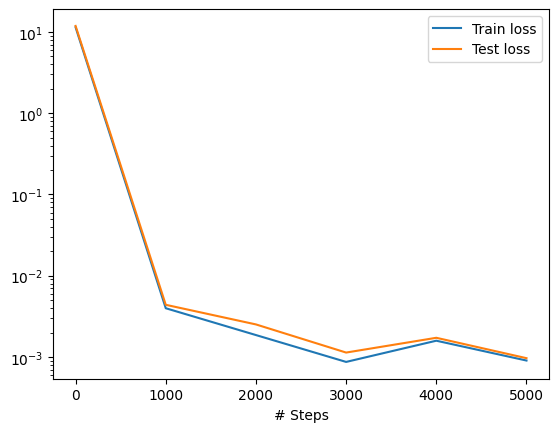

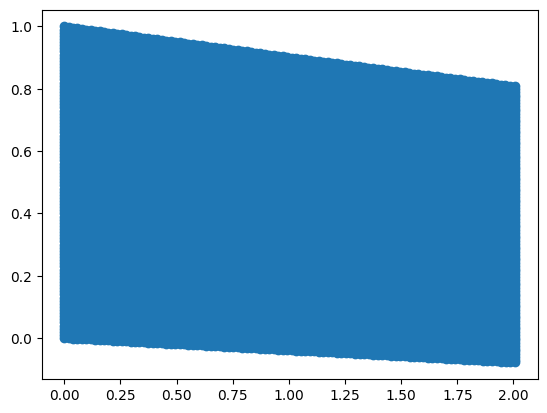

In [3]:
# PDE equation
def pde(xy, uv, aux):
    mu = 0.01
    nu = 0.49
    u, v = uv[..., 0:1], uv[..., 1:2]
    #u, v, p = uvp[..., 0:1], uvp[..., 1:2], uvp[..., 2:3]
    grad_u = dde.zcs.LazyGrad(xy, u)
    grad_v = dde.zcs.LazyGrad(xy, v)
    #grad_p = dde.zcs.LazyGrad(xy, p)
    # first order
    du_x = grad_u.compute((1, 0))
    dv_y = grad_v.compute((0, 1))
    #dp_x = grad_p.compute((1, 0))
    #dp_y = grad_p.compute((0, 1))
    # second order
    du_xx = grad_u.compute((2, 0))
    du_yy = grad_u.compute((0, 2))
    du_xy = grad_u.compute((1, 1))
    dv_xx = grad_v.compute((2, 0))
    dv_xy = grad_v.compute((1, 1))
    dv_yy = grad_v.compute((0, 2))
    Del2U = du_xx + du_yy + (1+nu)/(1-nu) * (du_xx + dv_xy)
    Del2V = dv_xx + dv_yy + (1+nu)/(1-nu) * (du_xy + dv_yy)

    #motion_x = mu * (du_xx + du_yy) - dp_x
    #motion_y = mu * (dv_xx + dv_yy) - dp_y
    #mass = du_x + dv_y
    #return motion_x, motion_y, mass
    return Del2U, Del2V

# Geometry
geom = dde.geometry.Rectangle([0, 0], [1, 1])


# Boundary condition
# other boundary conditions will be enforced by output transform

# Dirichlet bc on the right edge- U direction
def bc_right_U_func(x, aux_var):

    return  dde.backend.as_tensor( 1.  )  # uniform U =1 displacement
bc_right_U = dde.icbc.DirichletBC(
                                    geom=geom,
                                    func=bc_right_U_func,
                                    on_boundary=lambda x, on_boundary: np.isclose(x[0], 1.),
                                    component= 0 ) # component = 0 means x direction

# Dirichlet bc on the right edge- V direction
# def bc_right_V_func(x, aux_var):

#    return  dde.backend.as_tensor( 0. )

#bc_right_V = dde.icbc.DirichletBC(
#                                    geom=geom,
#                                    func=bc_right_V_func,
#                                    on_boundary=lambda x, on_boundary: np.isclose(x[0], 1.),
#                                    component= 1)

#def bc_slip_top_func(x, aux_var):
    # using (perturbation / 10 + 1) * x * (1 - x)
#    return (aux_var / 10 + 1.) * dde.backend.as_tensor(x[:, 0:1] * (1 - x[:, 0:1]))
#bc_slip_top = dde.icbc.DirichletBC(
#                                    geom=geom,
#                                    func=bc_slip_top_func,
#                                    on_boundary=lambda x, on_boundary: np.isclose(x[1], 1.),
#                                    component=0)
# PDE object
pde = dde.data.PDE(
    geom,
    pde,
    bcs=[bc_right_U ],
    num_domain=500,
    num_boundary=50,  # sampling a bit more points on boundary (1000 on top bc)
    num_test=100,
)

# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
n_pts_edge = 101  # using the size of true solution, but this is unnecessary
eval_pts = np.linspace(0, 1, num=n_pts_edge)[:, None]
data = dde.zcs.PDEOperatorCartesianProd(
    pde, func_space, eval_pts, num_function=1000,
    function_variables=[0], num_test=50, batch_size=100
)

# Net
net = dde.nn.DeepONetCartesianProd(
    [n_pts_edge, 128, 128, 128],
    [2, 128, 128, 128],
    "tanh",
    "Glorot normal",
    num_outputs=2,
    multi_output_strategy="independent"
)

# Output transform for zero boundary conditions
def out_transform(inputs, outputs):
    x, y = inputs[1][:, 0], inputs[1][:, 1]
    # horizontal displacement on left
    u = outputs[:, :, 0] * (x)[None, :]
    # vertical dis on left
    v = outputs[:, :, 1] * (x)[None, :]
    ## pressure on bottom
    #p = outputs[:, :, 2] * y[None, :]
    return dde.backend.stack((u, v), axis=2)
net.apply_output_transform(out_transform)

# Model
model = dde.zcs.Model(data, net)
model.compile("adam", lr=0.001, decay=("inverse time", 1000, 0.5))
losshistory, train_state = model.train(iterations=5000)
dde.utils.plot_loss_history(losshistory)
plt.show()

# save model if needed
# model.save('stokes_weights')

# Evaluation
func_feats = func_space.random(10)
v = func_space.eval_batch(func_feats, eval_pts)
v[:] = 0.  # true solution uses zero perturbation
xv, yv = np.meshgrid(eval_pts[:, 0], eval_pts[:, 0], indexing='ij')
xy = np.vstack((np.ravel(xv), np.ravel(yv))).T
sol_pred = model.predict((v, xy))[0]
#sol_true = np.load('../dataset/stokes.npz')['arr_0']
#print('Error on horizontal velocity:', dde.metrics.l2_relative_error(sol_true[:, 0], sol_pred[:, 0]))
#print('Error on vertical velocity:', dde.metrics.l2_relative_error(sol_true[:, 1], sol_pred[:, 1]))
#print('Error on pressure:', dde.metrics.l2_relative_error(sol_true[:, 2], sol_pred[:, 2]))
plt.figure(2)
def deform_coord(xy , sol_pred):
    return xy + sol_pred
deformed = deform_coord(xy , sol_pred)
plt.scatter(deformed[:,0],deformed[:,1])
plt.show()


In [ ]:
def Deformed_shape(xy, uv):
    x = xy[:,0]  # Original x coordinates
    y = xy[:,1]  # Original y coordinates
    u = uv[:,0]  # Random displacement in x direction
    v = uv[:,1]  # Random displacement in y direction


    # New coordinates after displacement

    x_new = x + u
    y_new = y + v

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5, label='Displacement (u, v)')
    plt.scatter(x, y, color='red', s=10, alpha=0.7, label='Original Nodes')
    plt.scatter(x_new, y_new, color='green', s=10, alpha=0.7, label='New Nodes')

    # Setting the limits for better visualization
    plt.xlim(-0.1, 2.1)  # Adjust the range based on your data
    plt.ylim(-0.1, 1.1)
    plt.grid()
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.title('Original and Displaced Nodes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

Deformed_shape(xy, sol_pred)